# Retrieve PNBOIA Argos data from CLS Server
Author: Marlon Santos e Henrique Pereira

In [52]:
%matplotlib inline
import re
import time  
import csv
from telnetlib import Telnet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [49]:
#input
programa = "05655"
saida = []
comando = "PRV,5655,DS,,"
n_argos_boia = 69153
boia = 'rig'

In [14]:
#conection telnet with CLS
try:
    tn = Telnet("65.210.29.2")
except Exception,e:
    print e

In [15]:
#login
try:
    tn.read_until("Username: ", timeout=10)
    tn.write("convidado" + "\n\r")
    tn.read_until("Password: ", timeout=5)
    tn.write("marinha" + "\n\r")
    print "Login com servidor de dados realizado..."# ,tn.read_until('SERVER', 5)
    print "Realizando coleta de dados para boia " + str(n_argos_boia) + "..."
except Exception, e:
    print e

Login com servidor de dados realizado...
Realizando coleta de dados para boia 69153...


In [16]:
#retrieve data
print comando
tn.write(str(comando) + str(n_argos_boia) + "\n\r")
dados = tn.read_until('SERVER', 5)
print "Dado recebidos: \n\r"
tn.close()

PRV,5655,DS,,
Dado recebidos: 



In [17]:
#separate string data
dados = dados.splitlines()
dados[3] = dados[3][1:]#remove \ for the 3th row

In [65]:
#put data in a table format
msg2 = []
for i in range(len(dados)):

    if dados[i][:5] == programa:
        
        if len(dados[i]) == 77: #verify if the message is complete

            if dados[i+1].split()[3] == '02':

                msg2.append(
                            #program, argos_id, date, time, lat, lon
                            list(np.array(dados[i].split())[[0,1,6,7,8,9]]) +
                            #sensor 0 - sensor 3 (msg, hour, ws, wg)
                            list(np.array(dados[i+1].split())[[3,4,5,6]]) +
                            #sensor 4 - sensor 7 (wd, at, rh, dwp)
                            list(np.array(dados[i+2].split())) +                                                         
                            #sensor 8 - sensor 11 (bp, sst, bhd, cla)
                            list(np.array(dados[i+3].split())) + 
                            #sensor 12 - sensor 15 (turb, solrad, cv1, cd1)
                            list(np.array(dados[i+4].split())) + 
                            #sensor 16 - 19 (cv2, cd2, cv3, cd3)
                            list(np.array(dados[i+5].split())) + 
                            #sensor 20 - 23 (hs, hmax, tp, dp)
                            list(np.array(dados[i+6].split())) + 
                            #sensor 24 - 26 (spr,sensor25, sensor26)
                            list(np.array(dados[i+7].split())) 
                            )                             

dd = pd.DataFrame(np.array(msg2),
                  columns=['program','argos_id','date','time','lat','lon','msg','hour','wind_spd',
                           'wind_gst','wind_dir','air_temp','rel_hum','dew_point','pressure',
                           'sst','buoy_head','_clr_a','turb','solar_rad','A1','A2','CM_vel_1','CM_dir_1',
                           'CM_vel_2','CM_dir_2','CM_vel_3','CM_dir_3','Hs','Hmax','Tp','Dp','Spr','spare1'])

#coloca nan nos dados nao numericos
dd = dd.convert_objects(convert_numeric=True)

#index as datetime
dd['datetime'] = pd.to_datetime([dd.date[i] + ' ' + dd.time[i] for i in range(len(dd))])
dd = dd.set_index('datetime')
dd = dd.drop(['date','time'], axis=1)

dd.to_csv(os.environ['HOME'] + '/Dropbox/database/pnboia/argos/' + boia + '.csv')

/usr/local/python/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:37: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


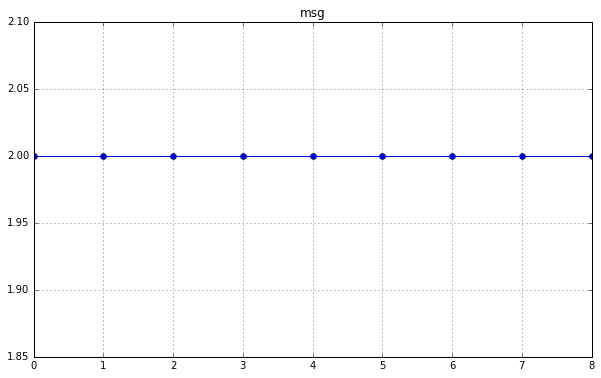

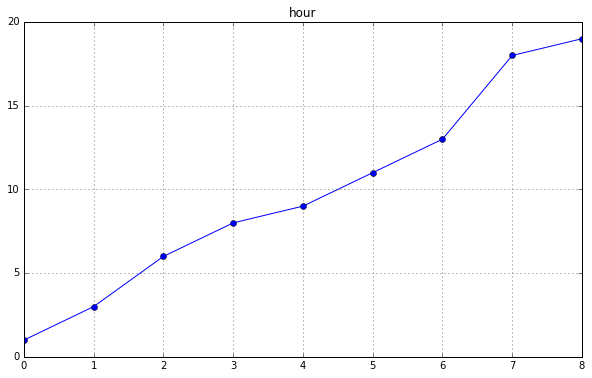

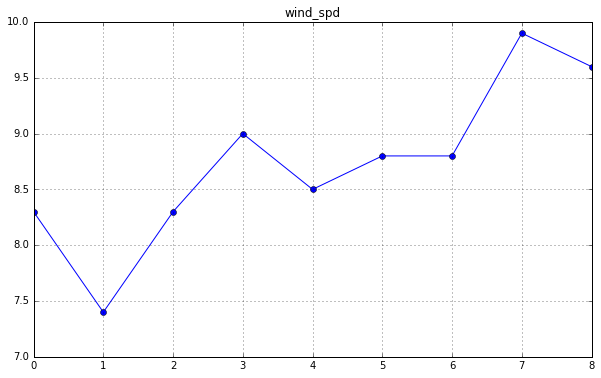

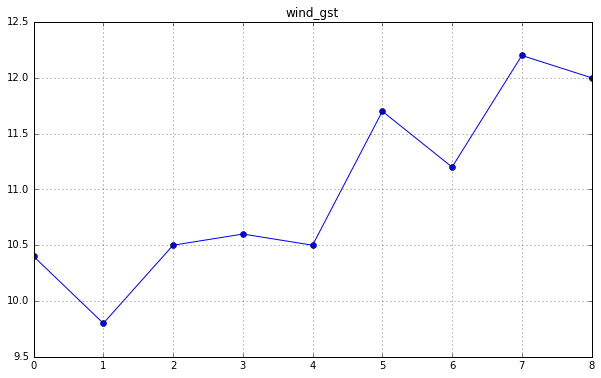

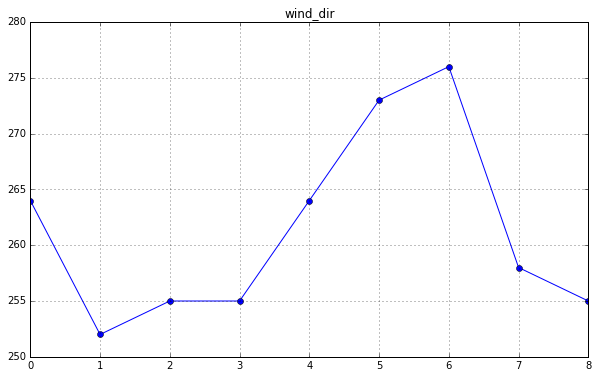

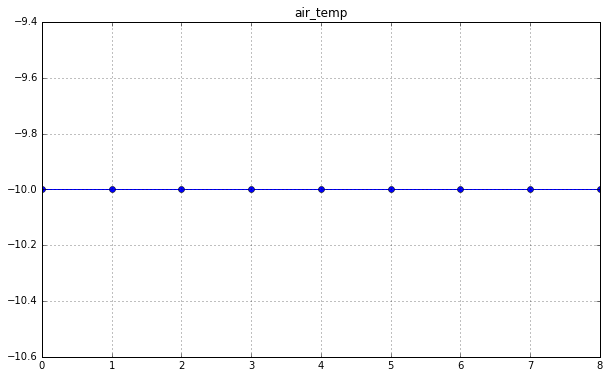

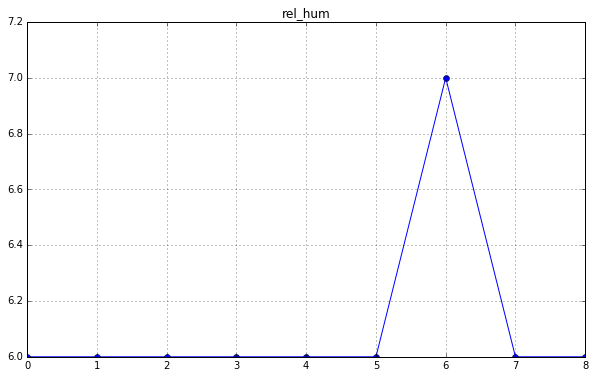

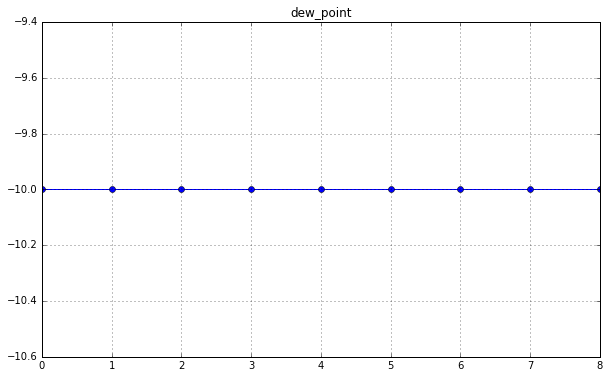

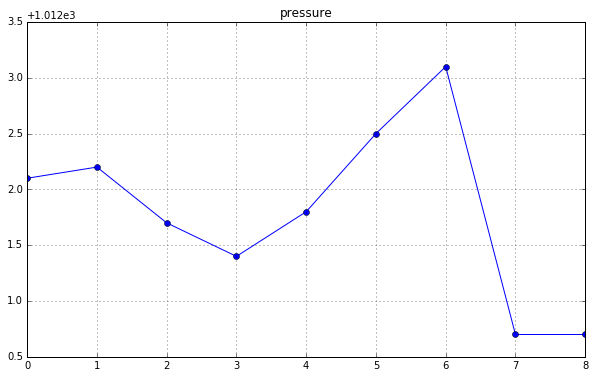

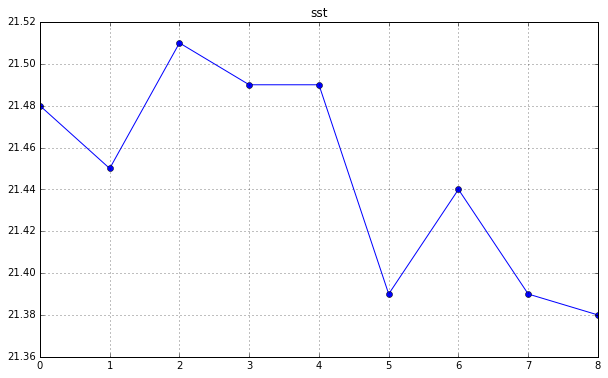

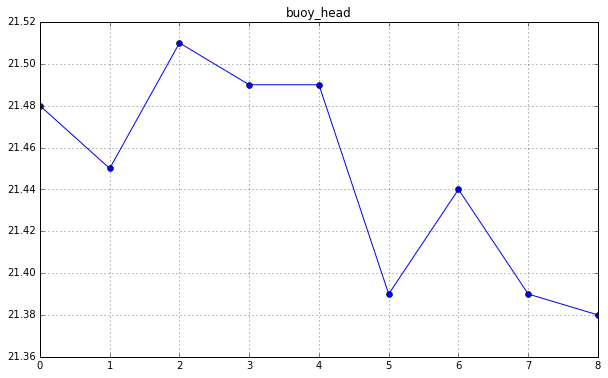

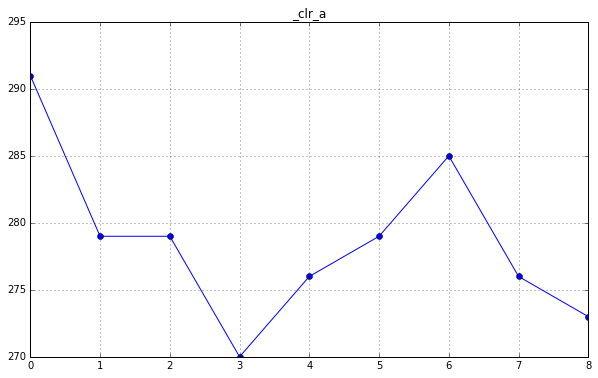

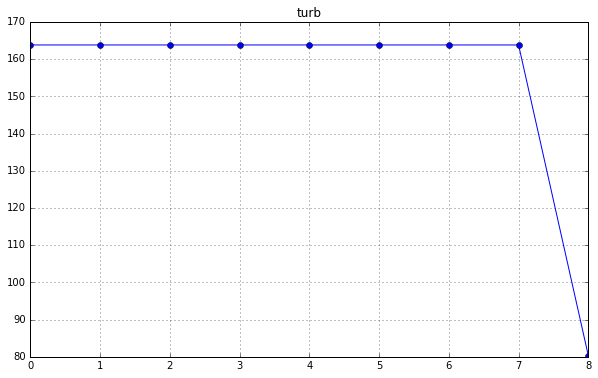

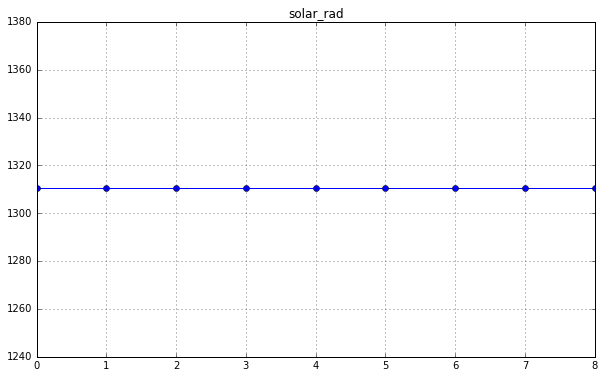

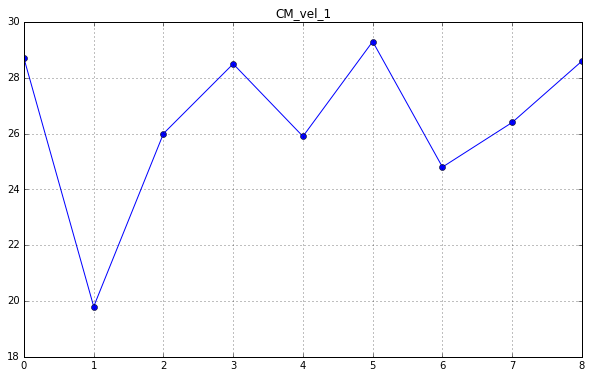

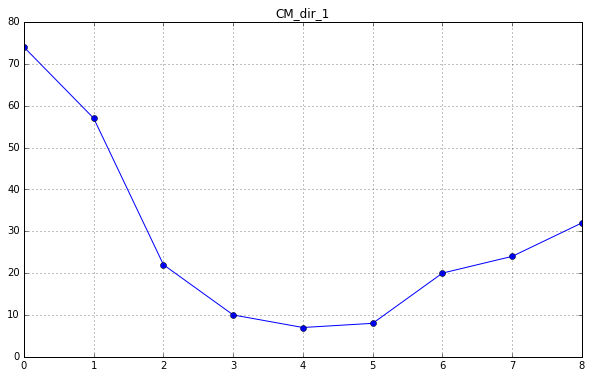

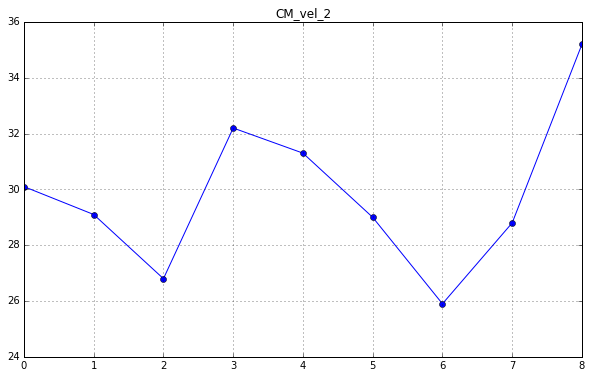

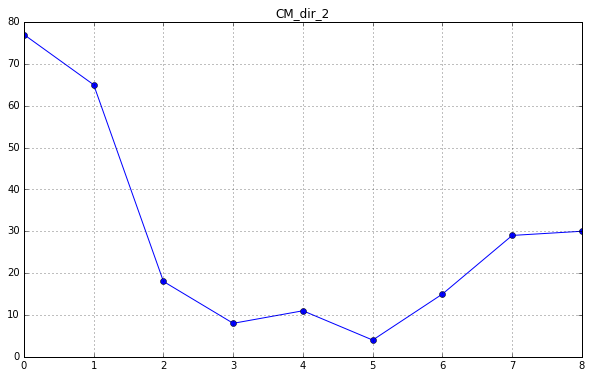

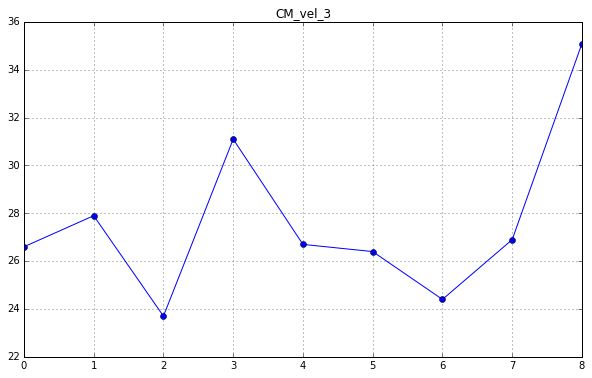

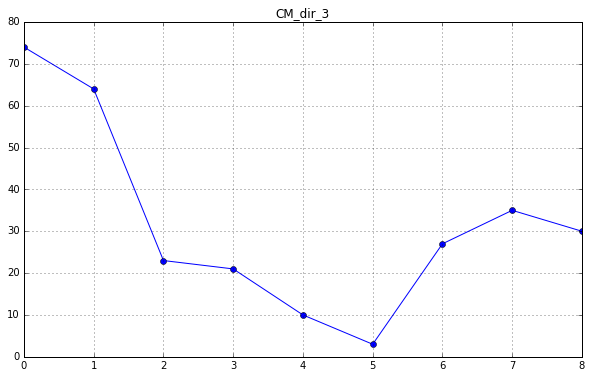

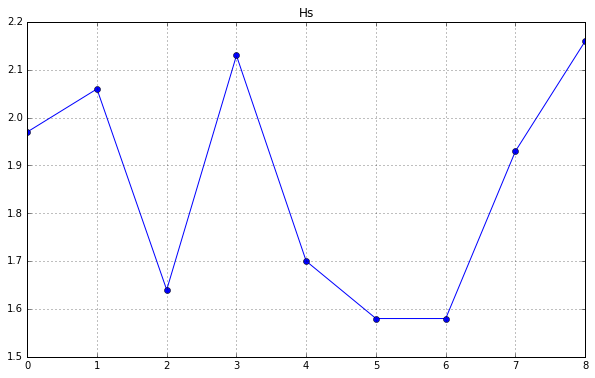

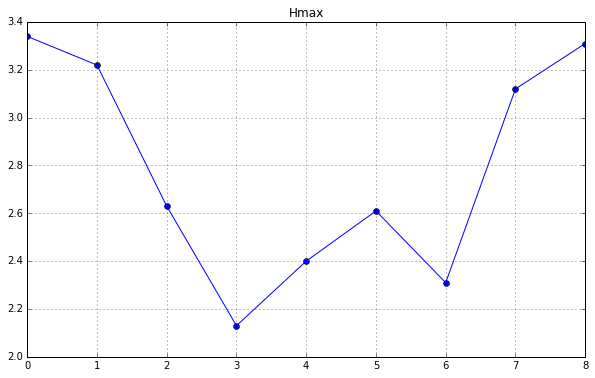

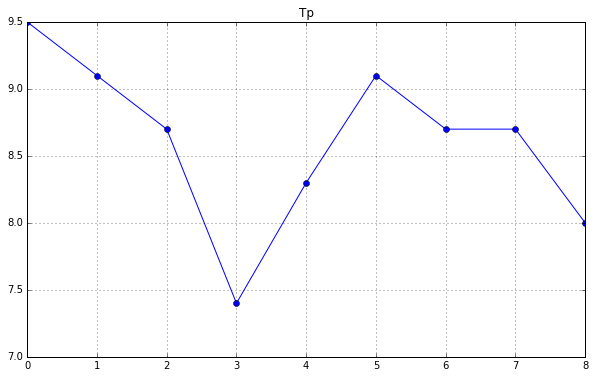

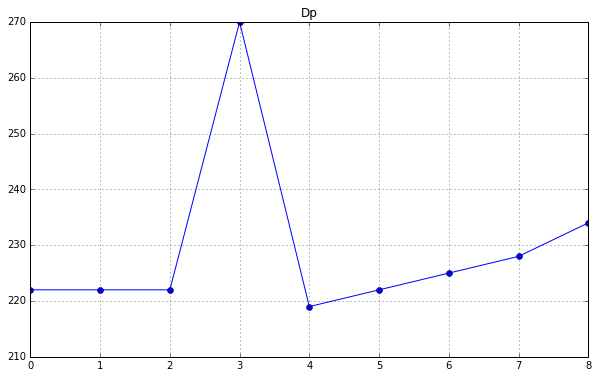

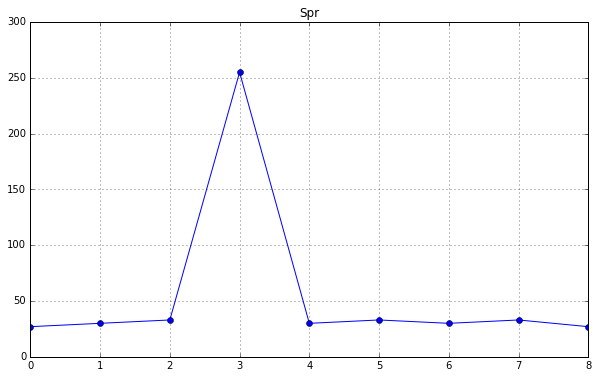

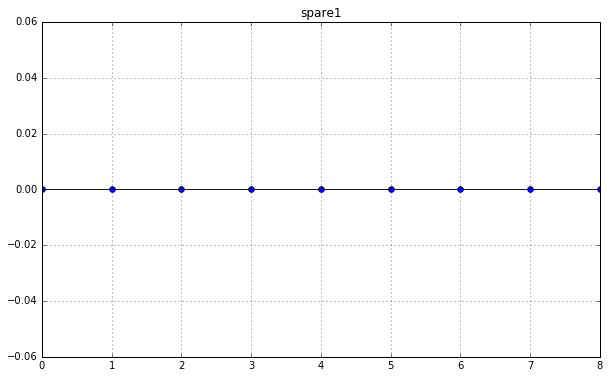

In [21]:
#plot variables

def plotpnboia(y, tit):
    
    plt.figure(figsize=(10,6))
    plt.plot(y,'-o')
    plt.grid()
    plt.title(tit)

var = ['msg','hour','wind_spd','wind_gst','wind_dir','air_temp','rel_hum','dew_point','pressure',
       'sst','buoy_head','_clr_a','turb','solar_rad','CM_vel_1','CM_dir_1','CM_vel_2','CM_dir_2',
       'CM_vel_3','CM_dir_3','Hs','Hmax','Tp','Dp','Spr','spare1']

for v in var:
    
    plotpnboia(dd[v], v)